In [1]:
import pandas as pd
import numpy as np

import sqlite3
import config


def query(sql: str) -> pd.DataFrame:
    """
    Execute a query and yield the results
    """
    conn = sqlite3.connect(config.DB_PATH)
    return pd.read_sql_query(sql, conn)

In [2]:
# CONFIG
field = "category"

In [3]:
# Load dataset
data = query(f"SELECT description as text, {field} as label FROM ledger_items where counterparty is not null")
data


,text,label
0,Bollettino Postale su c/c postale: 38187738,Home
1,Comm. Bollettino Postale su c/c postale: 38187738,Home
2,Bollettino Postale su c/c postale: 000076245836,Home
3,Comm. Bollettino Postale su c/c postale: 00007...,Home
4,"O/C: CLOUD ACADEMY SAGL IMP: 6.244,400 CHF CAM...",Salary
...,...,...
445,Netflix,Entertainment
446,netflix.com,Entertainment
447,netflix.com,Entertainment
448,netflix.com,Entertainment


In [4]:
data.isna().sum()

text     0
label    0
dtype: int64

<Axes: >

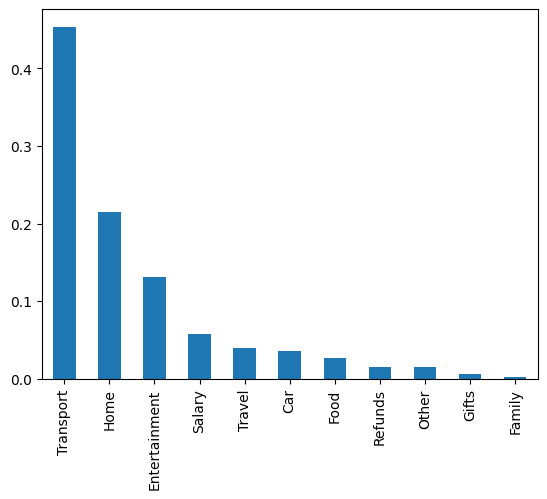

In [5]:
data['label'].value_counts(normalize = True).plot.bar()

In [6]:
import nltk
nltk.download('all')


# create a list text
text = list(data['text'])

# preprocessing loop
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def text_to_corpus(text: str) -> str:
    r = re.sub('[^a-zA-Z]', ' ', text)
    r = r.lower()
    r = r.split()
    r = [word for word in r if word not in stopwords.words('english')]
    r = [word for word in r if word not in stopwords.words('italian')]
    r = [lemmatizer.lemmatize(word) for word in r]
    return ' '.join(r)

#assign corpus to data['text']
data['corpus'] = data['text'].apply(text_to_corpus)
data.head()

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/lorenzo.mele/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/lorenzo.mele/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/lorenzo.mele/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/lorenzo.mele/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/lorenzo.mele/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_

,text,label,corpus
0,Bollettino Postale su c/c postale: 38187738,Home,bollettino postale postale
1,Comm. Bollettino Postale su c/c postale: 38187738,Home,comm bollettino postale postale
2,Bollettino Postale su c/c postale: 000076245836,Home,bollettino postale postale
3,Comm. Bollettino Postale su c/c postale: 00007...,Home,comm bollettino postale postale
4,"O/C: CLOUD ACADEMY SAGL IMP: 6.244,400 CHF CAM...",Salary,cloud academy sagl imp chf cam cau roc endtoen...


In [7]:
# Create Feature and Label sets
X = data['corpus']
y = data['label']

# train test split (66% train - 33% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)


print('Training Data :', X_train.shape)
print('Testing Data : ', X_test.shape)

Training Data : (301,)
Testing Data :  (149,)


In [8]:
# Train Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_train_cv.shape

(301, 161)

In [9]:
# Training Logistic Regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_cv, y_train)

def predict(text):
    # text = text_to_corpus(text)
    probability = model.predict_proba(cv.transform([text]))[0]
    probs = np.argsort(probability)
    highest = probs[-1]
    second = probs[-2]
    return model.classes_[highest], probability[highest], probability[highest]-probability[second]

data_copy = data.copy()
data_copy[['predict','proba','sureness']] = data_copy['text'].apply(predict).apply(pd.Series)
data_copy['check'] = data_copy['label'] == data_copy['predict']
data_copy['check'].value_counts(normalize = True)


True     0.96
False    0.04
Name: check, dtype: float64

In [11]:
# if the model is good, we can train it with the whole dataset and store it

# train model with the whole dataset
model.fit(cv.fit_transform(X), y)

from src.classifiers import store_classifier
# store_classifier(model, cv, field)
